# Three-Dimensional Permeability Inversion Using Convolutional Neural Networks and Positron Emission Tomography

## Prediction & Validation Using Experimental PET Data
Network Input: Experimental Normalized PET Arrival Time Difference Map (a.k.a. Experimental Arrival Time Map) \
Network Output: Predicted Permeability Map \
Forward Model Output: Modeled Normalized PET Arrival Time Difference Map (a.k.a. Modeled Arrival Time Map)\

Note: This notebook should be in the same directory with the network, the trained parameters (or the path file), the forward moddel, and the folder containing all the experimental arrival time maps. 

## Packages Loading

In [11]:
import os
import sys
import math
import time
import torch
import torch.nn as nn
import torchvision
import flopy
import sklearn
import itertools
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_scatter_density

from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, MultiStepLR
from sklearn.metrics import r2_score
from torch.nn import functional as F
from matplotlib.pylab import *
from matplotlib import ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap

Loading the Network

In [12]:
from EncDec3Do import Encoder, Decoder  # For the Homogeneous Porosity Case
#from EncDec3De import Encoder, Decoder # For the Heterogeneous Porosity Case

Loading the Forward Model

In [13]:
from flopy_arrival_time_3d_functions import mt3d_pulse_injection_sim, flopy_arrival_map_function

## Function for Drawing the Binned Scatter Plot (Experimental vs Modeled Arrival Time)

In [14]:
# Drawing the R2 Density
def c_plot(fig, labeled, decoded):
    x = labeled[labeled != 0]
    y = decoded[labeled != 0]

    yellow_pink = LinearSegmentedColormap.from_list('yellow_pink', [
        (0, '#ffffff'),
        (1e-20, 'red'),
        (0.2, '#ff57bb'),
        (0.4, '#faaaae'),
        (0.6, '#fdf1d2'),
        (0.8, '#f8eaad'),
        (1, 'yellow'),
    ], N=256)

    bin = plt.hexbin(x, y, gridsize=100, cmap=yellow_pink)


    plt.title('R2 = {:.3f}'.format(r2_score(x, y)),**cfont)

    ymax = np.max(y)
    ymin = np.min(y)
    plt.plot([ymin,ymax],[ymin,ymax], color = 'dimgray')
    plt.xlabel('Experimental Arrival Time',**cfont)
    plt.ylabel('Modeled Arrival Time',**cfont)

    return bin

## Loading and Pre-processing the Experimental PET Data for the Network

In [15]:
# =============================================================================
#     EXPERIMENTAL DATA LOADING
# =============================================================================
class InputDataset(Dataset):

    def __init__(self, transform=None):
        ## Input List for the Heterogeneous Porosity
        #input_list = [[]]
        
        # Input List for the Homogeneous Porosity
        input_list = []

        nlay = 20 # number of layers
        nrow = 20 # number of rows / grid cells
        ncol = 40 # number of columns (parallel to axis of core)

        # Loading the Experimental PET data
        exp_data_dir = os.path.join('.', 'Exp_Time')
        Normalized_BT_time = exp_data_dir + '/Berea_C1_2ml_2_3mm_at_norm.csv'
        #Normalized_BT_time = exp_data_dir + '/Indiana_2ml_2_3mm_at_norm.csv'
        #Normalized_BT_time = exp_data_dir + '/Edwards_2ml_2_3mm_at_norm.csv'
        #Normalized_BT_time = exp_data_dir + '/Ketton_4ml_2_2_3mm_at_norm.csv'
        
        # Loading the Porosity Data (.csv file for the heterogenous porosity case and nothing for the homogeneous porosity case)
        #pt_sp = './results/prsity.csv'

        # Import Core Shape Mask for Permeability Boundary Processing
        # Hard coded mask for 20x20 grid cross-section, this creates the a cylindrical shape core
        mp = np.array([7, 5, 3, 2, 2, 1, 1])
        mask_corner = np.ones((10,10))
        for i in range(len(mp)):
            mask_corner[i, 0:mp[i]] = 0

        mask_top = np.concatenate((mask_corner, np.fliplr(mask_corner)), axis=1)
        core_mask = np.concatenate((mask_top, np.flipud(mask_top)))
        ibound = np.repeat(core_mask[:, :, np.newaxis], ncol, axis=2)
        ibound = ibound.flatten()

        # Load the Arrival Time and Porosity Maps
        tdata_ex = np.loadtxt(Normalized_BT_time, delimiter=',', dtype= np.float32)
        #pt_ex = np.loadtxt(pt_sp, delimiter=',', dtype= np.float32)

        # Get the Geometric Mean Permeability of the Core
        k_mean = tdata_ex[-1]/np.float32(9.8692e-16)
        k_mean = np.sign(k_mean)*np.log(np.abs(k_mean))

        # Apply the Mask to the Experimental Arrival Time Data
        tdata_ex = tdata_ex[0:-1]
        tdata_ex[ibound == 0] = 0
        tdata_ex[ibound != 0] = np.sign(tdata_ex[ibound != 0])*np.log(np.abs(tdata_ex[ibound != 0]))

        ## Data Loading for the Heterogeneous Porosity
        #tdata_ex = tdata_ex.reshape(1,20,20,40)
        #pt_ex = pt_ex.reshape(1,20,20,40)
        #tdata_ex = np.flip(tdata_ex, 1)
        #tdata_ex = torch.from_numpy(tdata_ex.copy())
        #pt_ex = np.flip(pt_ex, 1)
        #pt_ex = torch.from_numpy(pt_ex.copy())
        #Pad = nn.ConstantPad3d((1,0,0,0,0,0), k_mean)
        #tdata_ex = Pad(tdata_ex)
        #pt_ex = Pad(pt_ex)
        
        #input_list[0].append(tdata_ex)
        #input_list[0].append(pt_ex)
        
        # Data Loading for the Homogeneous Porosity
        tdata_ex = tdata_ex.reshape(1,20,20,40)
        tdata_ex = np.flip(tdata_ex, 1)
        tdata_ex = torch.from_numpy(tdata_ex.copy())
        Pad = nn.ConstantPad3d((1,0,0,0,0,0), k_mean)
        tdata_ex = Pad(tdata_ex)
        input_list.append(tdata_ex)

        self.input = input_list
        self.k_mean = k_mean
        self.exp_data_dir = exp_data_dir
        self.ibound = ibound

## Making the Permeability Map Prediction

In [16]:
# =============================================================================
# IMAGE REGRESSION MODEL
# =============================================================================
# Initialize Dataset Object
dataset = InputDataset()
dataset_input = dataset.input[0:1]
dataloader_input = DataLoader(dataset=dataset_input, batch_size=1)

Tensor = torch.FloatTensor
encoder = Encoder()
decoder = Decoder()

# For the Homogeneous Porosity Case, use '..._epoch_281_85.pth' Path File.
# For the Heterogeneous Porosity Case, use '..._epoch_290_88.pth' Path File.
encoder.load_state_dict(torch.load('./encoder_epoch_281_85.pth', map_location='cpu'))
encoder.eval()

decoder.load_state_dict(torch.load('./decoder_epoch_281_85.pth', map_location='cpu'))
decoder.eval()

# Network Prediction for the Homogeneous Porosity Case
for i, (imgs_inp) in enumerate(dataloader_input):
    imgs_inp_N = Variable(imgs_inp.type(Tensor))
    encoded_imgs = encoder(imgs_inp_N)
    decoded_imgs = decoder(encoded_imgs)
    
## Network Prediction for the Heterogeneous Porosity Case 
#for i, (imgs_inp) in enumerate(dataloader_input):
#    for j, (image) in enumerate(imgs_inp):
#        # Get inputs and targets
#        if j == 0:
#            # The real input image with the mean permeability as boundary condition
#            true_inp = Variable(image.type(Tensor))
#        else:
#            prsity = Variable(image.type(Tensor))

#    inp = torch.cat((true_inp,prsity),1)
#    # Encoding-Decoding model
#    encoded_imgs = encoder(inp)
#    decoded_imgs = decoder(encoded_imgs)

## Obtaining and Post-processing the Predicted Permeability Map for the Forward Model

In [17]:
# Get the Permeability Map Prediction
enc_time = imgs_inp_N[0][0]
dec_perm = decoded_imgs[0][0]
enc_time = enc_time.cpu().detach().numpy()
dec_perm = dec_perm.cpu().detach().numpy()

enc_time = np.delete(enc_time,0,axis=2)
enc_time = enc_time.flatten()
dec_perm = dec_perm.flatten()

# Set Geometric Information of the Core
nlay = 20 # number of layers / grid cells
nrow = 20 # number of rows / grid cells
ncol = 40 # number of columns (along to axis of core)

enc_time[dataset.ibound == 0] = 0
enc_time[dataset.ibound != 0] = -1*np.sign(enc_time[dataset.ibound != 0])*np.exp(-1*np.sign(enc_time[dataset.ibound != 0])*enc_time[dataset.ibound != 0])
dec_perm[dataset.ibound == 0] = 0
dec_perm[dataset.ibound != 0] = np.exp(dec_perm[dataset.ibound != 0])
dec_perm = dec_perm*np.float32(9.8692e-16)

# Get the Mean and Standard Deviation of the Predicted Permeability Distribution
core_avg_perm = dec_perm[np.nonzero(dec_perm)].mean()
core_std_perm = dec_perm[np.nonzero(dec_perm)].std()
print('The core average permeability is: ' + str(core_avg_perm))
print('The standard deviation of the core permeability is: ' + str(core_std_perm))

dec_perm = dec_perm.reshape(20,20,40)
enc_time = enc_time.reshape(20,20,40)

The core average permeability is: 2.4692108e-14
The standard deviation of the core permeability is: 5.65566e-15


## Running the Forward Model on the Predicted Permeability Map to Obtain the Modeled Arrival Time Map

In [18]:
# =============================================================================
# FORWARD MODEL
# =============================================================================
# Mac PATHS
# Names of executable with path IF NOT IN CURRENT DIRECTORY
exe_name_mf = '/Users/zhuang296/Desktop/mac/mf2005'
exe_name_mt = '/Users/zhuang296/Desktop/mac/mt3dms'

## DELL 419 PATHS
## Names of executable with path IF NOT IN CURRENT DIRECTORY
#exe_name_mf = 'D:\\Dropbox\\Research\\Simulation\\modflow\\executables\\mf2005'
#exe_name_mt = 'D:\\Dropbox\\Research\\Simulation\\modflow\\executables\\mt3dms'

# Directory to Save Data
directory_name = '/Users/zhuang296/Desktop/FloPy1D'
workdir = os.path.join('.', directory_name)

# grid_size = [Grid Size in Direction of Lx (Layer Thickness),
# Ly (Left to Right Axis When Looking Down the Core), Lz (Long Axis of Core)]
grid_size = [0.23291, 0.23291, 0.25] # selected units [cm]

# Output Control for MT3dms
# nprs (int):  the frequency of the output. If nprs > 0 results will be saved at
# the times as specified in timprs (evenly allocated between 0 and sim run length);
# if nprs = 0, results will not be saved except at the end of simulation; if NPRS < 0, simulation results will be
# saved whenever the number of transport steps is an even multiple of nprs. (default is 0).
nprs = 150
# Period Length in Selected Units (for Steady State Flow, It Can Be Set to Anything)
perlen_mf = [1., 90]
# Numerical Method Flag
mixelm = -1

# Porosity of the Core (Only Use This for the Homogeneous Porosity Case)
#enc_prsity = 0.167 # Indiana
enc_prsity = 0.207 # Berea
#enc_prsity = 0.195 # Navajo
#enc_prsity = 0.251 # Bentheimer
#enc_prsity = 0.413 # Edwards
#enc_prsity = 0.250 # Estaillades
#enc_prsity = 0.230 # Ketton

# Model Workspace and New Sub-directory
model_dirname = ('t_forward')
model_ws = os.path.join(workdir, model_dirname)

# Convert Permeabiltiy (in m^2) to Hydraulic Conductivity in cm/min
raw_hk = dec_perm*(1000*9.81*100*60/8.9E-4)

# Get the Modeled Breakthrough Time Map
# Change How the Porosity Is Loaded Accordingly (np Array VS Scalar)
mf, mt, conc, timearray, km2_mean = mt3d_pulse_injection_sim(enc_prsity, model_dirname, model_ws, raw_hk, grid_size, perlen_mf, nprs, mixelm, exe_name_mf, exe_name_mt)
# Calculate Quantile Arrival Time Map from MT3D Simulation Results
at_array, at_array_norm, at_diff_norm = flopy_arrival_map_function(conc, np.array(timearray), grid_size, 0.5, 0.1)

# Get the Difference Between the Experimental and Modeled Arrival Time Data
diff_img = at_diff_norm - enc_time

Model run time: 7.9085 seconds
Arrival time function runtime: 6.1305 seconds


## Plotting the Center Slices of the Predicted and Modeled PET Arrival Time Maps (Qualitative Accessment)

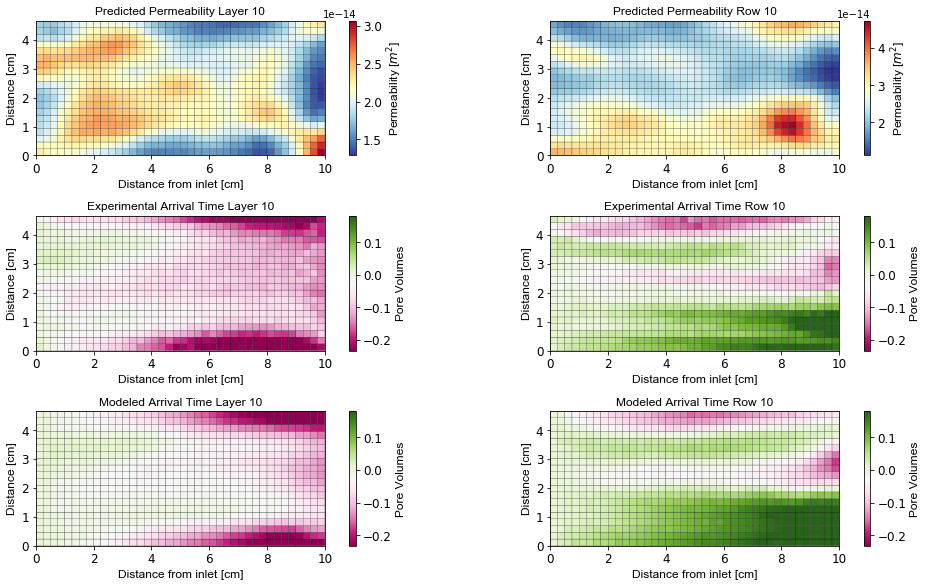

In [19]:
# =============================================================================
# PLOT DATA
# =============================================================================
# Layer to Plot
ilayer = 0
# Font
fs = 12
hfont = {'fontname':'Arial','size':fs}
# Font for the cross-plots
fsc = 24
cfont = {'fontname':'Arial','size':fsc}

# Define Grid
# Describe Grid for Results
Lx = ncol * grid_size[2]   # length of model in selected units
Ly = nrow * grid_size[1]   # length of model in selected units
y, x = np.mgrid[slice(0, Ly + grid_size[1], grid_size[1]),
                 slice(0, Lx + grid_size[2], grid_size[2])]

max = np.max(np.percentile(enc_time.flatten(),[1,99]))
min = np.min(np.percentile(enc_time.flatten(),[1,99]))

# Layer 10 of the Experimental Arrival Time Map
fig1 = plt.figure(figsize=(18, 9))
ax2 = fig1.add_subplot(3, 2, 3, aspect='equal')
imp = plt.pcolor(x, y, enc_time[round(nlay/2),:,:], cmap='PiYG', edgecolors='k', linewidths=0.2)
cbar = plt.colorbar()
cbar.set_label('Pore Volumes', fontsize=fs, **hfont)
cbar.ax.tick_params(labelsize= (fs))
ax2.set_xlabel('Distance from inlet [cm]', fontsize=fs-3, **hfont)
ax2.tick_params(axis='both', which='major', labelsize=fs)
plt.ylabel('Distance [cm]', fontsize=fs-3, **hfont)
plt.title('Experimental Arrival Time Layer 10', fontsize=fs, **hfont)
plt.clim(min, max)

# Layer 10 of the Modeled Arrival Time Map
ax2 = fig1.add_subplot(3, 2, 5, aspect='equal')
imp = plt.pcolor(x, y, at_diff_norm[round(nlay/2),:,:], cmap='PiYG', edgecolors='k', linewidths=0.2)
cbar = plt.colorbar()
cbar.set_label('Pore Volumes', fontsize=fs, **hfont)
cbar.ax.tick_params(labelsize= (fs))
ax2.set_xlabel('Distance from inlet [cm]', fontsize=fs-3, **hfont)
ax2.tick_params(axis='both', which='major', labelsize=fs)
plt.ylabel('Distance [cm]', fontsize=fs-3, **hfont)
plt.title('Modeled Arrival Time Layer 10', fontsize=fs, **hfont)
plt.clim(min, max)

# Layer 10 of the Predicted Permeability Map
ax2 = fig1.add_subplot(3, 2, 1, aspect='equal')
imp = plt.pcolor(x, y, dec_perm[round(nlay/2),:,:], cmap='RdYlBu_r', edgecolors='k', linewidths=0.2)
cbar = plt.colorbar()
cbar.set_label('Permeability [$m^{2}$]', fontsize=fs, **hfont)
cbar.ax.tick_params(labelsize= (fs))
ax2.set_xlabel('Distance from inlet [cm]', fontsize=fs-3, **hfont)
ax2.tick_params(axis='both', which='major', labelsize=fs)
plt.ylabel('Distance [cm]', fontsize=fs-3, **hfont)
plt.title('Predicted Permeability Layer 10', fontsize=fs, **hfont)
plt.clim(np.min(dec_perm[round(nlay/2),:,:]), np.max(dec_perm[round(nlay/2),:,:]))

# Row 10 of the Predicted Permeability Map
ax2 = fig1.add_subplot(3, 2, 2, aspect='equal')
imp = plt.pcolor(x, y, dec_perm[:,round(nrow/2),:], cmap='RdYlBu_r', edgecolors='k', linewidths=0.2)
cbar = plt.colorbar()
cbar.set_label('Permeability [$m^{2}$]', fontsize=fs, **hfont)
cbar.ax.tick_params(labelsize= (fs))
ax2.set_xlabel('Distance from inlet [cm]', fontsize=fs-3, **hfont)
ax2.tick_params(axis='both', which='major', labelsize=fs)
plt.ylabel('Distance [cm]', fontsize=fs-3, **hfont)
plt.title('Predicted Permeability Row 10', fontsize=fs, **hfont)
plt.clim(np.min(dec_perm[:,round(nrow/2),:]), np.max(dec_perm[:,round(nrow/2),:]))

# Row 10 of the Experimental Arrival Time Map
ax2 = fig1.add_subplot(3, 2, 4, aspect='equal')
imp = plt.pcolor(x, y, enc_time[:,round(nrow/2),:], cmap='PiYG', edgecolors='k', linewidths=0.2)
cbar = plt.colorbar()
cbar.set_label('Pore Volumes', fontsize=fs, **hfont)
cbar.ax.tick_params(labelsize= (fs))
ax2.set_xlabel('Distance from inlet [cm]', fontsize=fs-3, **hfont)
ax2.tick_params(axis='both', which='major', labelsize=fs)
plt.ylabel('Distance [cm]', fontsize=fs-3, **hfont)
plt.title('Experimental Arrival Time Row 10', fontsize=fs, **hfont)
plt.clim(min, max)

# Row 10 of the Modeled Arrival Time Map
ax2 = fig1.add_subplot(3, 2, 6, aspect='equal')
imp = plt.pcolor(x, y, at_diff_norm[:,round(nrow/2),:], cmap='PiYG', edgecolors='k', linewidths=0.2)
cbar = plt.colorbar()
cbar.set_label('Pore Volumes', fontsize=fs, **hfont)
cbar.ax.tick_params(labelsize= (fs))
ax2.set_xlabel('Distance from inlet [cm]', fontsize=fs-3, **hfont)
ax2.tick_params(axis='both', which='major', labelsize=fs)
plt.ylabel('Distance [cm]', fontsize=fs-3, **hfont)
plt.title('Modeled Arrival Time Row 10', fontsize=fs, **hfont)
plt.clim(min, max)

plt.subplots_adjust( bottom=0.15, top=0.96, wspace=0.05, hspace=0.45)
plt.show()

## Generating the Binned Scatter Plot between the Experimental and Modeled Arrival Time (Quantitative Accessment)

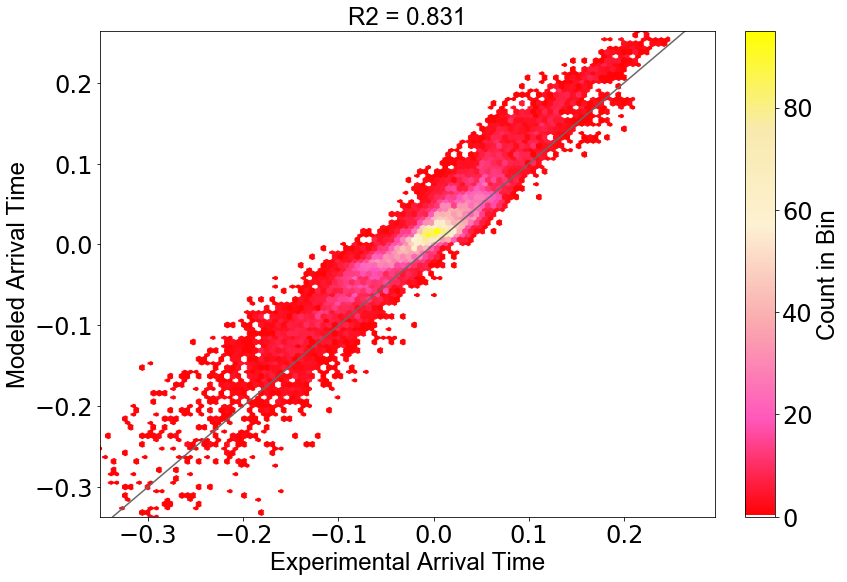

In [20]:
# Generate the Cross-plot between the Experimental and Modeled Arrival Time Maps
fig2 = plt.figure(figsize=(14, 9))
ax3 = fig2.add_subplot(111)
y = at_diff_norm[enc_time != 0].flatten()
x = enc_time[enc_time != 0].flatten()
bin_plt = c_plot(fig2, x, y)
fig2.subplots_adjust(left=0.18,right=0.79,top=0.9,bottom=0.15)
# L B W H
cbar_ax = fig2.add_axes([0.82, 0.15, 0.03, 0.75])
cbar2 = fig2.colorbar(bin_plt, cax=cbar_ax)
cbar2.set_label('Count in Bin', fontsize=fsc, **cfont)
for t in cbar2.ax.get_yticklabels():
     t.set_fontsize(fsc)
for item in (ax3.get_xticklabels() + ax3.get_yticklabels()):
    item.set_fontsize(fsc)
    
plt.show()